In [1]:
import numpy as np
import pandas as pd

from bootstrapped import bootstrap as bs
from bootstrapped import compare_functions as bs_cmp
from bootstrapped import stats_functions as bs_st

from scipy.stats import norm, mannwhitneyu, kruskal
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = min([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data,
            "value": pd_boot_data.quantile(0.5),
            "ci": ci,
            "p_value": p_value}

In [3]:
# готовый бустрап https://github.com/facebookarchive/bootstrapped
def facebook_bootstrap(test, control, stat_func, compare_func, alpha):
    dist = bs.bootstrap_ab(
        test,
        control,
        stat_func,
        compare_func,
        alpha=0.05,
        num_iterations=10000,
        iteration_batch_size=100,
        scale_test_by=1,
        num_threads=-1,
        return_distribution=True
    )
    
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(dist), 
        scale = np.std(dist)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(dist), 
        scale = np.std(dist)
    )
    p_value = min(p_1, p_2) * 2
    
    result = bs._get_confidence_interval(dist, [], 0.05, is_pivotal=False)
    
    # Визуализация
    plt.hist(dist, bins = 50)
    plt.style.use('ggplot')
    plt.vlines([result.lower_bound, result.upper_bound],ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {'result': result, 'p_value': p_value}

In [4]:
df = pd.read_csv('hw5.csv', sep=';', decimal=',', index_col=0)

In [5]:
df

,value,experimentVariant
1,9.773113,Treatment
2,9.311246,Treatment
3,11.172828,Treatment
4,11.624510,Treatment
5,10.462331,Treatment
...,...,...
546,10.973929,Control
547,10.261074,Control
548,8.780090,Control
549,11.169078,Control


In [6]:
df.groupby(['experimentVariant']).agg(['count', 'mean'])

value           
                  count       mean
experimentVariant                 
Control             500  10.026867
Treatment            50  10.367236

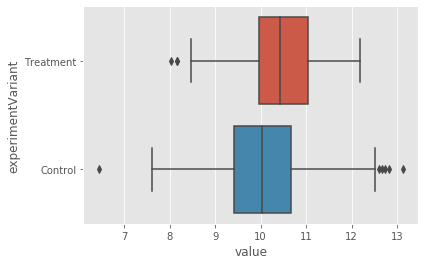

In [7]:
viz1 = sns.boxplot(x='value',y='experimentVariant', data=df)

In [8]:
test_sample = np.array(df[df['experimentVariant'] == 'Treatment']['value'])
control_sample = np.array(df[df['experimentVariant'] == 'Control']['value'])

### Mean diff bootstrap

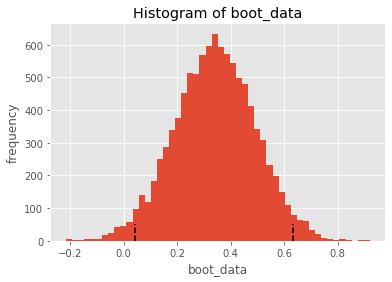

p-value:  0.02394279001087329
is significant:  True
diff value:  0.3417548027445836
diff ci:  (0.041680370754189386, 0.6314215345420423)


In [9]:
bootstrap_mean = facebook_bootstrap(
    test_sample,
    control_sample,
    bs_st.mean,
    bs_cmp.difference,
    0.05
)

print('p-value: ', bootstrap_mean['p_value'])
print('is significant: ', bootstrap_mean['result'].is_significant())
print('diff value: ', bootstrap_mean['result'].value)
print('diff ci: ', (bootstrap_mean['result'].lower_bound, bootstrap_mean['result'].upper_bound))

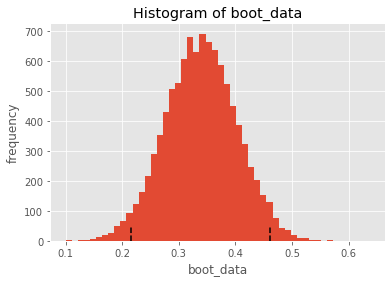

p-value:  6.525994956905224e-08
diff value:  0.3396736913756013
diff ci:  0.025    0.215497
0.975    0.460993
Name: 0, dtype: float64


In [10]:
booted_mean_data = get_bootstrap(
    df[df['experimentVariant'] == 'Treatment']['value'],
    df[df['experimentVariant'] == 'Control']['value'],
    boot_it = 10000
)

print('p-value: ', booted_mean_data['p_value'])
print('diff value: ', booted_mean_data['value'][0])
print('diff ci: ', booted_mean_data['ci'][0])

### Median diff bootstrap

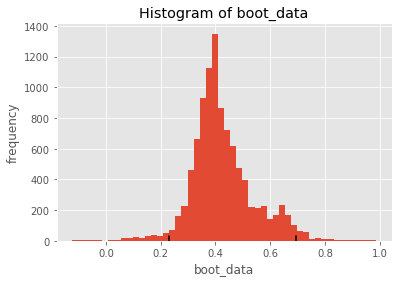

p-value:  0.00025442755809602295
is significant:  True
diff value:  0.40580112444290073
diff ci:  (0.22968854350833415, 0.6937607151950321)


In [11]:
bootstrap_median = facebook_bootstrap(
    test_sample,
    control_sample,
    bs_st.median,
    bs_cmp.difference,
    0.05
)

print('p-value: ', bootstrap_median['p_value'])
print('is significant: ', bootstrap_median['result'].is_significant())
print('diff value: ', bootstrap_median['result'].value)
print('diff ci: ', (bootstrap_median['result'].lower_bound, bootstrap_median['result'].upper_bound))

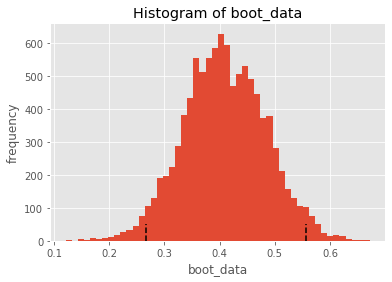

p-value:  3.31481543402701e-08
diff value:  0.4074859142799001
diff ci:  0.025    0.266134
0.975    0.556643
Name: 0, dtype: float64


In [12]:
booted_median_data = get_bootstrap(
    df[df['experimentVariant'] == 'Treatment']['value'],
    df[df['experimentVariant'] == 'Control']['value'],
    boot_it = 10000,
    statistic = np.median
)

print('p-value: ', booted_median_data['p_value'])
print('diff value: ', booted_median_data['value'][0])
print('diff ci: ', booted_median_data['ci'][0])

### Mann-Whitneyu

In [13]:
mw_res = mannwhitneyu(test_sample, control_sample, alternative='two-sided')

print("Mann-Whitney rank test")
print("u =", mw_res[0])
print("p-value =", mw_res[1])

Mann-Whitney rank test
u = 15492.0
p-value = 0.005236419587596797


### Kruskal-Wallis H-test

In [14]:
kruskal(test_sample, control_sample)

KruskalResult(statistic=7.7985312522685035, pvalue=0.005228871996769007)